In [1]:
# Setting up the Colab page to use neqsim
%%capture
!pip install neqsim
from neqsim.process import openprocess
import urllib
import time
# Importing the gas-oil process from file
!wget https://github.com/equinor/neqsimprocess/raw/master/lib/offshorePro.neqsim

#Documentation
https://github.com/equinor/neqsimprocess/blob/master/doc/oilstabilizationprocess.pdf


In [2]:
# importing the process from the stored file
# See: https://github.com/equinor/neqsimprocess/blob/master/src/neqsimprocess/oilgasprocess/sepproces.java
# See Figure 1 for process flow diagram
GasOilProcess = openprocess('offshorePro.neqsim')

## figure oil process
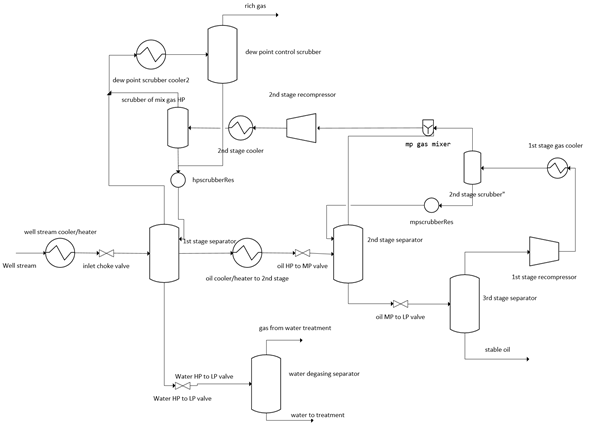

In [3]:
from neqsim.process import openprocess
import time
import pandas as pd
from neqsim.thermo import createfluid,fluid_df,TPflash
# Read gas-oil process from file

# Uncomment to create alternative well stream
wellStreamComposition = {'ComponentName':  ["nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "water"], 
        'MolarComposition[-]':  [0.53, 3.3, 72.98, 7.68, 4.1, 0.7, 1.42, 0.54, 0.67, 0.85, 1.33, 1.33, 0.78, 0.61, 0.42, 0.33, 0.42, 0.24, 0.3, 0.17, 0.21, 0.15, 0.15, 0.8, 10.0], 
        'MolarMass[kg/mol]': [None,None, None,None,None,None,None,None,None,None,0.0913, 0.1041, 0.1188, 0.136, 0.150, 0.164, 0.179, 0.188, 0.204, 0.216, 0.236, 0.253, 0.27, 0.391, None],
        'RelativeDensity[-]': [None,None, None,None,None,None,None,None,None,None, 0.746, 0.768, 0.79, 0.787, 0.793, 0.804, 0.817, 0.83, 0.835, 0.843, 0.837, 0.84, 0.85, 0.877, None]
  } 

wellStreamCompositiondf = pd.DataFrame(wellStreamComposition) 
wellStream = fluid_df(wellStreamCompositiondf)
GasOilProcess.getUnit("well stream").setThermoSystem(wellStream)

GasOilProcess.getUnit("well stream").setFlowRate(12.23, 'MSm3/day')
GasOilProcess.getUnit("well stream").setPressure(120.0, "bara")
GasOilProcess.getUnit("well stream").setTemperature(65.0, "C")
GasOilProcess.getUnit("well stream cooler/heater").setOutTemperature(66.0, "C")
GasOilProcess.getUnit("well stream cooler/heater").setOutPressure(52.21, "bara")
GasOilProcess.getUnit("inlet choke valve").setOutletPressure(51.21, "bara")
GasOilProcess.getUnit("1st stage separator").setEntrainment(0.1, "", "oil", "aqueous")
GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(15.0, "bara")
GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(85.0, "C")
GasOilProcess.getUnit("oil MP to LP valve").setOutletPressure(1.8, "bara")
GasOilProcess.getUnit("Water HP to LP valve").setOutletPressure(1.01325, "bara")
GasOilProcess.getUnit("dew point scrubber cooler2").setOutTemperature(33.0, "C")
GasOilProcess.getUnit("2nd stage cooler").setOutTemperature(33.0, "C")
GasOilProcess.getUnit("1st stage gas heat exchanger").setOutTemperature(33.0, "C")
GasOilProcess.getUnit("1st stage recompressor").setIsentropicEfficiency(0.75)
GasOilProcess.getUnit("2nd stage recompressor").setIsentropicEfficiency(0.75)

In [4]:
#Run the process calculations
tic = time.perf_counter()
GasOilProcess.run()
toc = time.perf_counter()
print(f"Simulation run in {toc - tic:0.4f} seconds")

Simulation run in 17.2840 seconds


In [5]:
#Read results
GasLiqidRatio = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
cooler1Duty = GasOilProcess.getUnit("1st stage gas heat exchanger").getDuty()/1e3
cooler2Duty = GasOilProcess.getUnit("2nd stage cooler").getDuty()/1e3

wellStreamFLowMSm3day = GasOilProcess.getUnit("well stream").getFluid().getFlowRate("MSm3/day")
richGasFLowMSm3day = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day")
gasInletSepFlowMSm3day = GasOilProcess.getUnit("1st stage separator").getGasOutStream().getFluid().getFlowRate("MSm3/day")
stableOilFLowm3hr = GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
waterToTreatmentRatem3hr = GasOilProcess.getUnit("water to treatment").getFluid().getFlowRate("m3/hr")
resycleFLowDewPointScrubber = GasOilProcess.getUnit("dew point control scrubber").getLiquidOutStream().getFluid().getFlowRate("kg/hr")
GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/ GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
TVPofexportoil = GasOilProcess.getUnit("stable oil").TVP(30.0, "C")
CCB_exportgas = GasOilProcess.getUnit("rich gas").CCB("bara")
CCT_exportgas = GasOilProcess.getUnit("rich gas").CCT("C")

In [6]:
print("rich gas flow", richGasFLowMSm3day, " MSm3/day")
print("1st stage recompressor power", compressorPower1, " kW")
print("2nd stage recompressor power", compressorPower2, " kW")
print("1st stage gas cooler duty ", cooler1Duty, " kW")
print("2nd stage cooler duty ", cooler2Duty, " kW")
print("stable oil production ", stableOilFLowm3hr, " me/hr")
print("rich gas production ", richGasFLowMSm3day, " MS3/day")
print("GOR ", GOR)
print("TVP of export oil ", TVPofexportoil)
print("cricondenbar pressure of rich gas ", CCB_exportgas, " bara")
print("cricondentherm temperature of rich gas ", CCT_exportgas, " C")

rich gas flow 10.012216612881383  MSm3/day
1st stage recompressor power 848.7369915675836  kW
2nd stage recompressor power 893.359292678422  kW
1st stage gas cooler duty  -2571.732327598746  kW
2nd stage cooler duty  -2080.2472942950017  kW
stable oil production  302.40819921119964  me/hr
rich gas production  10.012216612881383  MS3/day
GOR  1379.5118429048896
TVP of export oil  0.9259054487657034
cricondenbar pressure of rich gas  83.0634228039951  bara
cricondentherm temperature of rich gas  -15.955990140724964  C


#Case study - effect of second stage pressure/temperature
In the following simulation we will evaluate the effect of second stage pressure/temperature on total compressor power.


Text(0, 0.5, 'Power [kW]')

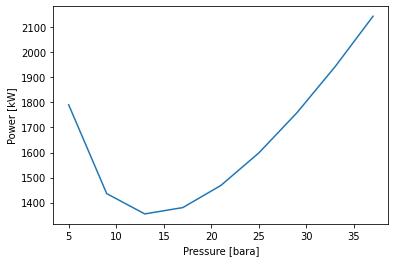

In [7]:
import numpy as np
import matplotlib.pyplot as plt

minPressure = 5.0  #@param {type:"number"}
maxPressure = 40.0  #@param {type:"number"}
pressure = np.arange(minPressure, maxPressure, int((maxPressure-minPressure)/10)+1)
GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(40.0, "C")

def casestudypressure(pressure):
  GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(pressure, "bara")
  GasOilProcess.run()
  compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
  compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
  totalPower = compressorPower1+compressorPower2
  return totalPower

totalpower = [casestudypressure(P) for P in pressure]

plt.figure()
plt.plot(pressure, totalpower)
plt.xlabel('Pressure [bara]')
plt.ylabel('Power [kW]')


Text(0, 0.5, 'Power [kW]')

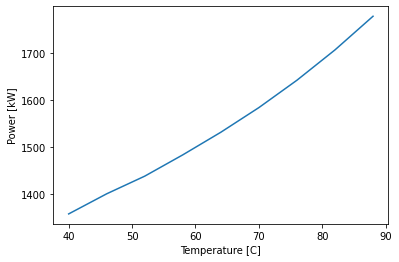

In [8]:
minTemperature = 40.0  #@param {type:"number"}
maxTemperature = 90.0  #@param {type:"number"}
temperature = np.arange(minTemperature, maxTemperature, int((maxTemperature-minTemperature)/10)+1)
GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(15.0 , "bara")

def casestudytemperature(temperature):
  GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(temperature, "C")
  GasOilProcess.run()
  compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
  compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
  totalPower = compressorPower1+compressorPower2
  return totalPower

totalpower = [casestudytemperature(T) for T in temperature]

plt.figure()
plt.plot(temperature, totalpower)
plt.xlabel('Temperature [C]')
plt.ylabel('Power [kW]')

#Optimization of the process
In the following example we will use the SciPy optimizer to find the pressure/temperature if the second stage separator to minimize compressor work. Constrains are set to get correct oil and gas specifiactions, and to keep compression ratio within limits..

In [9]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
x0 = np.array([52.0, 35.0])

minPressure = 5.0  #@param {type:"number"}
maxPressure = 40.0  #@param {type:"number"}
minTemperature = 40.0  #@param {type:"number"}
maxTemperature = 90.0  #@param {type:"number"}
boundTemperature    = (minTemperature, maxTemperature) 
boundPressure    = (minPressure, maxPressure) 
bnds = (boundTemperature, boundPressure)

maxPressureRatioCompressor = 10.0
maxCricondenbar= 110.0
maxTVP = 0.93

#Setting constrains on pressure ratio of compressors (10), and TVP of oil and cricondebar of rich gas
cons=({'type': 'ineq',
       'fun': lambda x:  maxPressureRatioCompressor-x[1]/GasOilProcess.getUnit("3rd stage separator").getGasOutStream().getPressure("bara")},
      {'type': 'ineq',
       'fun': lambda x:  maxPressureRatioCompressor-GasOilProcess.getUnit("1st stage separator").getGasOutStream().getPressure("bara")/x[1]},
      {'type': 'ineq',
       'fun': lambda x:  maxTVP-GasOilProcess.getUnit("stable oil").TVP(30.0, "C")},
      {'type': 'ineq',
       'fun': lambda x:  maxCricondenbar-GasOilProcess.getUnit("rich gas").CCB("bara")}
      )

def optfunc(x):
    temperature1 = x[0]
    pressure1 = x[1] 
    GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(temperature1, "C")
    GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(pressure1, "bara")
    GasOilProcess.run()
    compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
    compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
    totalPower = compressorPower1+compressorPower2
    print("power ", totalPower, " temperature ", temperature1, " pressure ", pressure1)
    return totalPower

res = minimize(optfunc, x0,bounds=bnds, options={'eps':0.1},constraints=cons)
print(res)


print("TVP ", GasOilProcess.getUnit("stable oil").TVP(30.0, "C"))
print("Cricondebar ", GasOilProcess.getUnit("rich gas").CCB("bara"))
print("pressure ratio recomp1 ", str(GasOilProcess.getUnit("1st stage separator").getGasOutStream().getPressure("bara")/GasOilProcess.getUnit("2nd stage separator").getGasOutStream().getPressure("bara")))
print("pressure ratio recomp1 " ,str(GasOilProcess.getUnit("2nd stage separator").getGasOutStream().getPressure("bara")/GasOilProcess.getUnit("3rd stage separator").getGasOutStream().getPressure("bara")))

power  2098.2621321730394  temperature  52.0  pressure  35.0
power  2098.2617323935197  temperature  52.0  pressure  35.0
power  2098.8384009961637  temperature  52.1  pressure  35.0
power  2103.3159053324066  temperature  52.0  pressure  35.1
power  1946.5668919673064  temperature  46.233313973559234  pressure  5.0
power  1706.6605953083947  temperature  50.37523456907924  pressure  26.547491452780324
power  1706.6603012221085  temperature  50.37523456907924  pressure  26.547491452780324
power  1707.1996802239387  temperature  50.47523456907924  pressure  26.547491452780324
power  1710.586533659421  temperature  50.37523456907924  pressure  26.647491452780326
power  1828.5254114506736  temperature  41.63286574253022  pressure  5.0
power  1610.7341980694594  temperature  49.37750058877501  pressure  24.088356538743486
power  1683.5925305437381  temperature  50.14578392554695  pressure  25.981959858490605
power  1701.1079329311115  temperature  50.32052524504065  pressure  26.4126482866

#TVP of export oil and CCB of rich gas as function of HP oil heater
In the following example we calculate the TVP of the export oil and cricondenbar of the rich export gas as function of temperature of the oil after the heater.


Text(0, 0.5, 'recompressor power [MW]')

<Figure size 432x288 with 0 Axes>

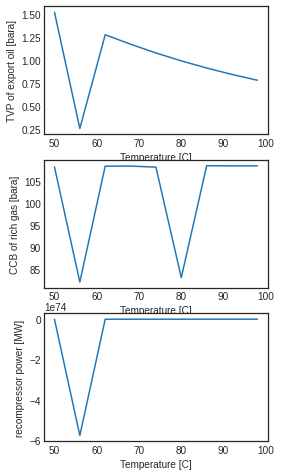

In [11]:
import numpy as np
import matplotlib.pyplot as plt

minTemperature = 50.0  #@param {type:"number"}
maxTemperature = 100.0  #@param {type:"number"}
temperature = np.arange(minTemperature, maxTemperature, int((maxTemperature-minTemperature)/10)+1)
GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(15.0, "bara")

def casestudyTVP(temp):
  GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(temp, "C")
  GasOilProcess.run()
  return GasOilProcess.getUnit("stable oil").TVP(30.0, "C")

def CCB(temp):
  GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(temp, "C")
  GasOilProcess.run()
  return GasOilProcess.getUnit("rich gas").CCB("bara")

def recompressorpower(temp):
  GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(temp, "C")
  GasOilProcess.run()
  compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e6
  compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e6
  return compressorPower1+compressorPower2

TVPcase = [casestudyTVP(T) for T in temperature]
CCBcase = [CCB(T) for T in temperature]
recomppower = [recompressorpower(T) for T in temperature]


plt.figure()
plt.figure(figsize=(4,8))
plt.style.use('seaborn-white')
plt.subplot(3, 1, 1)
plt.plot(temperature, TVPcase)
plt.xlabel('Temperature [C]')
plt.ylabel('TVP of export oil [bara]')
plt.subplot(3, 1, 2)
plt.plot(temperature, CCBcase)
plt.xlabel('Temperature [C]')
plt.ylabel('CCB of rich gas [bara]')
plt.subplot(3, 1, 3)
plt.plot(temperature, recomppower)
plt.xlabel('Temperature [C]')
plt.ylabel('recompressor power [MW]')

